# **Homework 2: Logistic regression** - CAP 4630 - Artificial Intelligence

#### *Imports*

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer

#### *Given Stratified split function*

In [ ]:
# Stratified split: 60/20/20
def stratifiedSplit(X, y, rng, trainFrac=0.6, valFrac=0.2):
    classes = np.unique(y)
    idxTrain, idxVal, idxTest = [], [], []

    for c in classes:
        idx_c = np.where(y==c)[0]
        rng.shuffle(idx_c)
        n = len(idx_c)
        nTrain = int(trainFrac*n)
        nVal = int(valFrac*n)
        idxTrain.extend(idx_c[:nTrain])
        idxVal.extend(idx_c[nTrain:nTrain+nVal])
        idxTest.extend(idx_c[nTrain+nVal:])

    return np.array(idxTrain), np.array(idxVal), np.array(idxTest)

## **General Initialization**

In [ ]:
# Loading Data
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X, y = data.data, data.target

# Global epsilon variable
eps = 1e-12

### Splitting the data into Training, Validation, and Testing portions
Splitting the data into 3 parts (Training, Validation, and Testing) allows us to train our model on one set of variables, validate the testing with another set of variable, and the gauge how well the training went with a final testing set

In [ ]:
rng = np.random.default_rng()
idxTrain, idxVal, idxTest = stratifiedSplit(X, y, rng)
XTrain, yTrain = X[idxTrain], y[idxTrain]
XVal, yVal = X[idxVal], y[idxVal]
XTest, yTest = X[idxTest], y[idxTest]
print("\nSplits:", XTrain.shape, XVal.shape, XTest.shape)


Splits: (341, 30) (113, 30) (115, 30)


### Standardizing the Data
Standardizing the data ensures the no part of the data is weighted more than it should be.
We also add an intercept term.

In [ ]:
# Adding an intercept (bias) term
X = np.c_[np.ones(X.shape[0]), X]

# Standardizing the data
mean = XTrain[:, 1:].mean(axis=0)
std = XTrain[:, 1:].std(axis=0) + eps
XTrain[:, 1:] = (XTrain[:, 1:] - mean) / std
XVal[:, 1:] = (XVal[:, 1:] - mean) / std
XTest[:, 1:] = (XTest[:, 1:] - mean) / std

## **Training the Model**
#### *Setting Parameters and Global Variables*
Our learning rate will affect our rate of gradient decent. We keep it low to prevent diverging from the answer.
Lambda is the parameter we use to control L2 Regularization.
nIterations controls how many iterations of gradient decent we are doing.

Theta will hold our final weight values after we complete all iterations

I found that using a low learning rate (0.05) prevented the model from diverging for the first few iterations.
Keeping lambda low also allowed us to have a smooth loss curve

In [ ]:
learningRate = 0.05
Lambda = 0.05
nIterations = 6000

# This will hold our final weights
theta = np.zeros(XTrain.shape[1])
trainingLosses, valueLosses = [], []

### Solving for Theta (weights) using logistic regression
Solving for theta is the same in logistic regression as it is in linear regression, except we are putting the resulting vector into a sigmoid function to ensure that we get a percentage between 0 and 1

We will calculate our loss using binary cross-entropy which is the derivative of the loss function

In [ ]:
for i in range(nIterations):
    # Finding our hypothesized values through matrix multiplication
    # We put the result into a sigmoid function 1 / (1 + e^(XTrain * theta))
    n = len(yTrain)
    h = 1 / (1 + np.exp(-(XTrain.dot(theta))))

    # Calculating the loss function
    loss = (1/n) * XTrain.T.dot(h - yTrain)
    # Regularization (this prevents us from overfitting to the data)
    gradient = Lambda*theta + loss
    gradient[0] = loss[0]

    # Updating our theta (weights) values
    theta -= learningRate * gradient

    # Finding losses using binary cross-entropy
    # This will be the derivative of the loss function
    n = len(yTrain)
    regularization = (Lambda/2) * np.sum(theta[1:]**2)

    hTrain = 1 / (1 + np.exp(-(XTrain.dot(theta))))
    hTrain = np.clip(hTrain, eps, 1-eps)
    trainingLoss = -1/n * np.sum(yTrain*np.log(hTrain) + (1-yTrain)*np.log(1-hTrain))
    trainingLoss += regularization

    hVal = 1 / (1 + np.exp(-(XVal.dot(theta))))
    hVal = np.clip(hVal, eps, 1-eps)
    valueLoss = -1/n * np.sum(yVal*np.log(hVal) + (1-yVal)*np.log(1-hVal))
    valueLoss += regularization

    # Keeping track of how are loss and validation functions are changing
    trainingLosses.append(trainingLoss)
    valueLosses.append(valueLoss)

## **Plotting the Loss and Validation Functions**

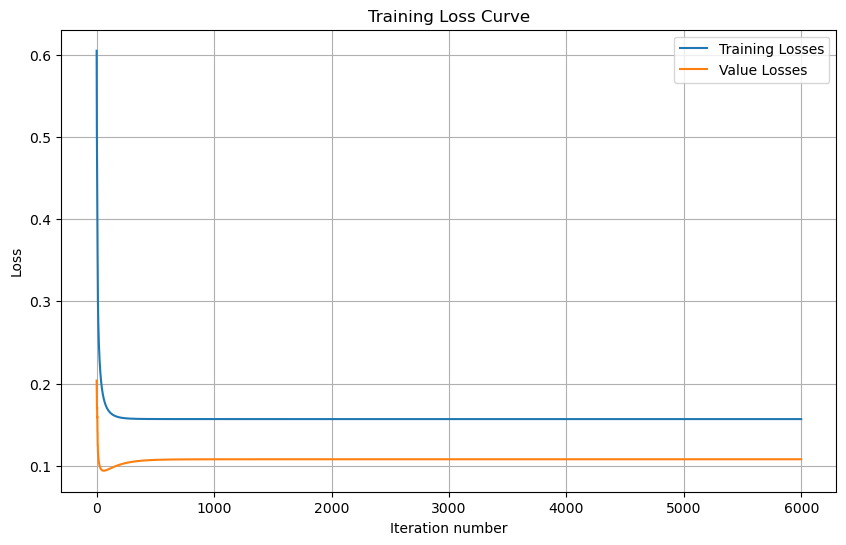

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(nIterations), trainingLosses, label='Training Losses')
plt.plot(range(nIterations), valueLosses, label='Value Losses')
plt.title('Training Loss Curve')
plt.xlabel('Iteration number')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## **Evaluating the Model**
### Running the Model on Test Data

In [ ]:
# Calculating our predictions for if the cancer is benign or malignent using our computed weights (theta)
probabilities = 1 / (1 + np.exp(-(XTest.dot(theta))))
predictions = (probabilities >= 0.5).astype(int)

# Finding the true results from the data
TP, TN, FP, FN = 0, 0, 0, 0

# For each result from the test data, we compare our predicted result to the actual result and we update our:
# True Positive, False Positive, True Negative, and False Negative varibles 
for actual, predicted in zip(yTest, predictions):
    if actual == 1 and predicted == 1: TP += 1
    if actual == 0 and predicted == 1: FP += 1
    if actual == 1 and predicted == 0: FN += 1
    if actual == 0 and predicted == 0: TN += 1

### Calculating our Evaluation Variables

In [ ]:
# Calculating accuracy
if len(yTest) > 0: accuracy = (TP + TN) / len(yTest)
else: accuracy = 0
# Calculating precision
if (TP+FP) > 0: precision = TP / (TP + FP)
else: precision = 0
# Calculating recall
if (TP + FN) > 0: recall = TP / (TP + FN)
else: recall = 0
# Calculating F1
if (precision + recall) > 0: f1 = 2 * (precision * recall) / (precision + recall)
else: f1 = 0
# Calculating TPR = recall
TPR = recall
# Calculating FPR
if (FP + TN) > 0: FPR = FP / (FP+TN)
else: FPR = 0

### Evaluation Metrics

In [ ]:
print(f"--------------------")
print(f"   TP: {TP}  |  FN {FN}")
print(f"--------------------")
print(f"   FP: {FP}   |  TN {TN}")
print(f"--------------------\n")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"TPR (Recall): {TPR}")
print(f"FPR: {FPR}\n")

--------------------
   TP: 72  |  FN 0
--------------------
   FP: 3   |  TN 40
--------------------

Accuracy: 0.9739130434782609
Precision: 0.96
Recall: 1.0
F1-Score: 0.9795918367346939
TPR (Recall): 1.0
FPR: 0.06976744186046512



## **Final Results**
### Learned Coefficients (Thetas)
These coefficients are what we use when checking if the cancer is benign or malignent with new test data

In [ ]:
print(theta)

[ 0.03073227 -0.29638104 -0.41742757 -0.39309425 -0.22650761 -0.16196541
 -0.29855466 -0.43949393 -0.10565936  0.17431765 -0.31207099  0.01310128
 -0.24571468 -0.28626045 -0.04292106  0.09688551  0.08807563 -0.08965717
  0.10588096  0.17565339 -0.42902587 -0.38352225 -0.40380994 -0.37899405
 -0.27372453 -0.17558887 -0.25701109 -0.38385869 -0.20156658 -0.07196073]


### Probabilities/Classes for the First 5 Test Examples
For each of the probabilities, it is classified as 0 if it is less than 0.5 and 1 if it is at leat 0.5


In [ ]:
print(f"Probabilities  | Class")
print("---------------|-------")
for i in range(min(5, probabilities.size)):
    print(f"{probabilities[i]:.10f}   |   {predictions[i]}")

Probabilities  | Class
---------------|-------
0.0000036580   |   0
0.1615944490   |   0
0.0028915242   |   0
0.0029825766   |   0
0.1063870922   |   0
